# Bayesian Uncertainty Analysis vs MCMC

_Camu Prins, TU Delft, March 2025_

In this notebook, the Bayesian uncertainty analysis (Emcee) is compared to the MCMC uncertainty analysis. The Bayesian uncertainty method is further elaborated on in the example of [Bayesian uncertainty analysis](https://pastas.readthedocs.io/latest/examples/uncertainty_emcee.html) and the MCMC analysis has been conducted by Van Der Spek & Bakker (2017), which can be found [Here](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704). 

First, for the Emcee analysis, a Pastas model is created. Then, the confidence and predicitive intervals are calculated using an EmceeSolver for comparison to the MCMC analyses.

The notebook uses data from DINO loket, which can be downloaded from their [website](https://www.dinoloket.nl/ondergrondgegevens), and data from KNMI, which is automatically downloaded using HydroPandas. 

In [1]:
import hydropandas as hpd
import pandas as pd
import corner
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as st
import emcee
from tabulate import tabulate

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.3
SciPy version: 1.11.1
Matplotlib version: 3.7.2
Numba version: 0.57.0


In [2]:
# Make list with all the ground water data using gobs
file_pattern = r"data/B*.csv"                             # File patern to look for groundwater heads
file_paths = glob.glob(file_pattern)                      # Find all files that match the pattern
gw_levels_list = []  
for file_path in file_paths:
    gw_data = hpd.GroundwaterObs.from_dino(file_path)
    gw_levels_list.append(gw_data)     

Now, all the groundwater data is in a list with easy access. In this specific notebook, I am comparing the results from an MCMC analysis by Van der Spek at groundwater well B32E0031 to an Emcee uncertainty analysis and then looping over the rest of the wells for a quick comparison.

## 1. Create a model using EmceeSolver:

First, let's create a model using the EmceeSolver. We start by gathering all the necessary data for the analysis. From the groundwater level list, groundwater well B32E0031 is chosen, and the corresponding evaporation and precipitation data are downloaded from the KNMI.

In [3]:
# Load data
gw_levels = gw_levels_list[8]                                # No8 is B32E0031

# Make sure all data has a biweekly sampling frequency.
series = gw_levels["stand_m_tov_nap"].dropna()                                        # Get rid of Nan-values
ref_tindex = series.resample('2W').first().index                                      # Create a biweekly reference frame, select the first available value in each period
tindex = series.index                                                                 # Get original time index
sel_index = ps.timeseries_utils.get_sample(tindex=tindex, ref_tindex=ref_tindex)      # Find the index closest to the ref_tindex, and then return a selection of the index.
series = series.loc[sel_index]     

The series is resampled in a biweekly reference frame for easy comparison between the wells. In the past, and still in some wells, the head was measured every two weeks. Nowadays, daily measurements are not uncommon.

Next, we set the start time and duration to ensure a 20-year simulation period for all wells.

In [4]:
# Set proper time parameters:
time = str(gw_levels.index[-1].year - 10)                             # End simulation time is 10 year before end of timeseries, So that later we could validate over 10 years.

if gw_levels.index[0].year < (gw_levels.index[-1].year - 30):         # Set start time to 30 years in the past, to make sure you have space for calibration and validation
    strtime = str(int(time) - 20)                                       
else:
    strtime = str(gw_levels.index[0].year + 1)                        # Pick the first complete year of the time series.
    time = str(int(strtime) + 20)                                     # If the time series is shorter then 30 years, make sure there is a calibration period of20 years

    
# Load evaportation and precipitation data from KNMI using hydropandas
evaporation = hpd.EvaporationObs.from_knmi(          
    meteo_var="EV24",                         # EV24; to get evaporation from the nearest weather station
    stn=260,                                  # Stn 260 is the Bilt: Normally, use 'xy= ...', however as we are comparing to vd Spek, we select the same wheather station as in her research.
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,                    #  Fill missing values with values from the nearest KNMI station.
)

precipitation = hpd.PrecipitationObs.from_knmi(
    xy=(gw_levels.x, gw_levels.y),           # Get nearest station
    meteo_var= 'RD',                         # RD; the daily precipitaiton from nearest precipitation station
    start=gw_levels.index[0],
    end=gw_levels.index[-1],
    fill_missing_obs=True,                   #  Fill missing values with values from the nearest KNMI station.
)


# A check to compare the data to vd Spek
print(f"name: {evaporation.name} SHOULD BE De Bilt")
print(f"name: {precipitation.name} SHOULD be Putten")
print(f"name: {gw_levels.name} SHOULD be B32E0031")

name: EV24_DE-BILT SHOULD BE De Bilt
name: RD_PUTTEN-GLD SHOULD be Putten
name: B32E0031-001 SHOULD be B32E0031


After all the data is downloaded, we can start building a linear recharge model with a Gamma response function. The model is first solved using a regular solver to obtain a good estimate of the initial parameter values.

Here are some checks:
- Ensure the units are correct.
- Set the correct time frame for the solver.

We also add a noise model to later calculate the variance of the noise. This will serve as an initial estimate for a parameter in the EmceeSolver.

In [5]:
# BUILD MODEL
ml = ps.Model(series, name= gw_levels.name)
ts1 = ps.RechargeModel(
    precipitation["RD"].resample("D").first() * 1000,       # Mind the UNITS !
    evaporation["EV24"].resample("D").first() * 1000,
    rfunc=ps.Gamma(),
    name="rainevap",
    recharge=ps.rch.Linear(),
    settings=("prec", "evap"),
)
ml.add_stressmodel(ts1)

nm = ps.ArNoiseModel()
ml.add_noisemodel(nm)

# SOLVE MODEL
# In the loop we solve as follows:
# ml.solve(tmin=strtime ,tmax=gw_levels.index[-1], report=False)    
# However, we compare with vd Spek and use the same timeframe in the example:ml.solve(tmin='1969' ,tmax='2002', report=False) 
ml.solve(tmin='1969' ,tmax='2002', report=True) 

Fit report B32E0031-001           Fit Statistics
nfev    23                     EVP         83.75
nobs    749                    R2           0.84
noise   True                   RMSE         0.19
tmin    1969-01-01 00:00:00    AICc     -3403.68
tmax    2002-01-01 00:00:00    BIC      -3376.08
freq    D                      Obj          3.92
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (6 optimized)
                optimal    initial  vary
rainevap_A     0.875586   0.198992  True
rainevap_n     0.907259   1.000000  True
rainevap_a   253.646633  10.000000  True
rainevap_f    -1.047122  -1.000000  True
constant_d    10.766816  11.561566  True
noise_alpha   92.230241  15.000000  True

Warnings! (1)
Response tmax for 'rainevap' > than warmup period.


## 1a. Set priors:

For the Emcee solver, the first step is to select priors for the parameters. In this case, we are using uniform priors and setting pmin and pmax to ensure the parameters remain within a reasonable range.

In [6]:
# Set the initial parameters to a normal distribution
ml.parameters["initial"] = ml.parameters["optimal"]  # set initial value to the optimal from least squares for good starting point
for name in ml.parameters.index:
    if ml.parameters.loc[name, "optimal"] > 0:
        ml.set_parameter(name, dist="uniform",pmin=0.25 * ml.parameters.loc[name, "optimal"], pmax=4 * ml.parameters.loc[name, "optimal"])
    else:
        ml.set_parameter(name, dist="uniform", pmin=4 * ml.parameters.loc[name, "optimal"],pmax=0.25 * ml.parameters.loc[name, "optimal"])

ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
rainevap_A,0.875586,0.218896,3.502344,True,rainevap,uniform,0.070892,0.875586
rainevap_n,0.907259,0.226815,3.629037,True,rainevap,uniform,0.017344,0.907259
rainevap_a,253.646633,63.411658,1014.586533,True,rainevap,uniform,30.691962,253.646633
rainevap_f,-1.047122,-4.188489,-0.261781,True,rainevap,uniform,0.074679,-1.047122
constant_d,10.766816,2.691704,43.067264,True,constant,uniform,0.122070,10.766816
noise_alpha,92.230241,23.057560,368.920965,True,noise,uniform,12.787650,92.230241


## 1b. Create the Solver Instance
The next step is to create the solver instance. Here, the objective function, the number of iterations, and the solver method are specified. The GaussianLikelihoodAR1 and DEMove functions are used. An explanation of how the solver works can be found on [readthedocs](https://emcee.readthedocs.io/en/stable/).

In [7]:
# Choose the objective function of the Emce solver
ln_prob = ps.objfunc.GaussianLikelihoodAr1()

# Create the EmceeSolver with some settings
s = ps.EmceeSolve(
    nwalkers=20,
    moves=emcee.moves.DEMove(),
    objective_function=ln_prob,
    progress_bar=True,
    parallel=False,
)

The initial parameter of ln_var is set to the variance of the noise. This provides a good initial estimate and reduces the number of steps necessary to reach the optimal value.

After the parameter is modified, the noise model is deleted again, as the EmceeSolver has a built-in function that handles the noise.

In [8]:
s.parameters.loc["ln_var", "initial"] = np.var(ml.noise())     # 
s.parameters.loc["ln_var", "pmin"] = np.var(ml.noise()) / 4
s.parameters.loc["ln_var", "pmax"] = 4 * np.var(ml.noise())

ml.del_noisemodel()      #                                         
s.parameters

,initial,pmin,pmax,vary,stderr,name,dist
ln_var,0.010629,2.657264e-03,0.042516,True,0.01,ln,uniform
ln_phi,0.500000,1.000000e-10,0.999990,True,0.20,ln,uniform


## 1c. Run the solver

In [9]:
ml.solve(
    solver=s,
    initial=False,
    fit_constant=True,
    tmin='1969',
    tmax='2002',
    steps=1000,
    tune=True,
)

100%|██████████| 1000/1000 [01:19<00:00, 12.52it/s]

Fit report B32E0031-001           Fit Statistics
nfev    nan                    EVP         83.67
nobs    749                    R2           0.84
noise   False                  RMSE         0.19
tmin    1969-01-01 00:00:00    AICc     -2448.00
tmax    2002-01-01 00:00:00    BIC      -2424.99
freq    D                      Obj           nan
warmup  3650 days 00:00:00     ___              
solver  EmceeSolve             Interp.        No

Parameters (5 optimized)
               optimal     initial  vary
rainevap_A    0.895377    0.875586  True
rainevap_n    0.904578    0.907259  True
rainevap_a  261.966700  253.646633  True
rainevap_f   -1.051734   -1.047122  True
constant_d   10.738806   10.766816  True

Warnings! (1)
Response tmax for 'rainevap' > than warmup period.


## 2 Plot Parameter Distribution

Below, a corner plot is created to check the parameter distribution and the covariances between the parameters. The parameters should form a well-defined cloud of points. If this does not happen, some settings may need to be adjusted.

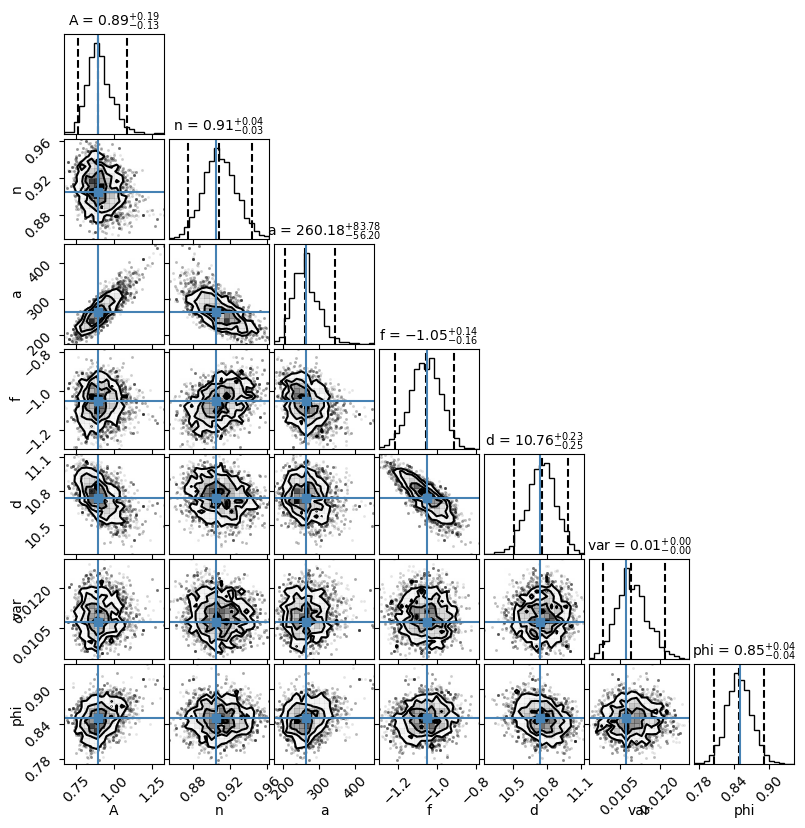

In [10]:
# Corner plot of the results
fig = plt.figure(figsize=(8, 8))

labels = list(ml.parameters.index[ml.parameters.vary]) + list(
    ml.solver.parameters.index[ml.solver.parameters.vary]
)
labels = [label.split("_")[1] for label in labels]

best = list(ml.parameters[ml.parameters.vary].optimal) + list(
    ml.solver.parameters[ml.solver.parameters.vary].optimal
)

axes = corner.corner(
    ml.solver.sampler.get_chain(flat=True, discard=500),
    quantiles=[0.025, 0.5, 0.975],
    labelpad=0.1,
    show_titles=True,
    title_kwargs=dict(fontsize=10),
    label_kwargs=dict(fontsize=10),
    max_n_ticks=3,
    fig=fig,
    labels=labels,
    truths=best,
)

plt.show()

## 3. The Trace of the Walkers
The walkers take steps in different directions at each step. After a number of steps, it is expected that their movement becomes random. This is a sign that an optimum has been found.

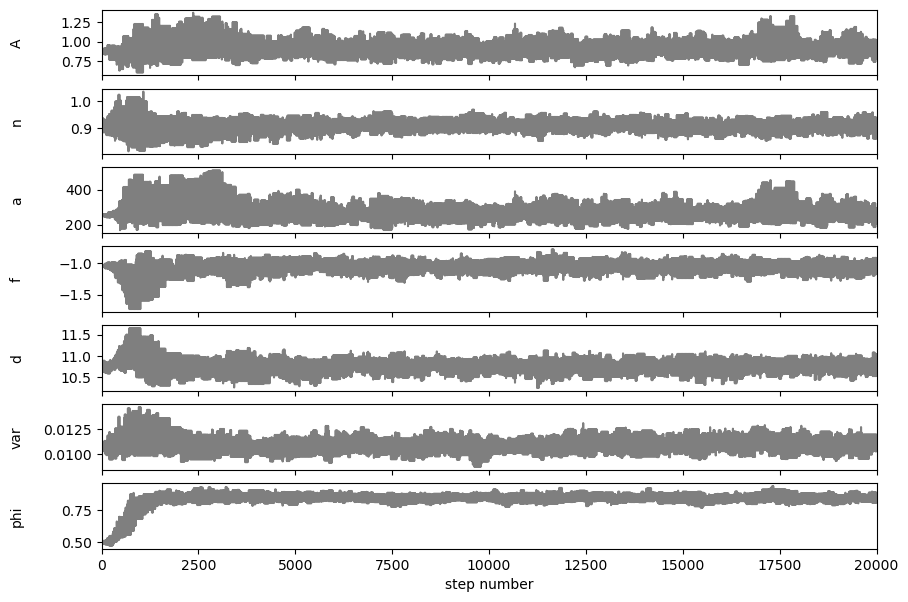

In [11]:
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)

samples = ml.solver.sampler.get_chain(flat=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

For further comparison, the response time and the Nash-Sucliff efficiency are calculated as well

In [12]:
step_response = ml.get_step_response('rainevap')
T90 = step_response.index[step_response.values >= 0.90 * ml.parameters.loc['rainevap_A', 'optimal']][0]
print(f"Response time (T90): {T90} days")

Response time (T90): 560.0 days


In [13]:
print(f'The NSE: {ml.stats.nse():.3f}')

The NSE: 0.836


## 4. Evaluate the uncertainty

Now that the solver is complete. We can extract the chain that holds different parameter combinations. This chain can be used to determine the confidence interval and the prediction interval.

### 4a. Confidence interval

To determine the confidence interval, we loop over the different parameter sets and simulate the head with each set. Here we discard the first 500 iterations to ensure that only the parameters that have finished 'walking' are used. The remaining parameter sets are used for simulation. The 0.975th and the 0.025th quantiles of the heads are determined and we get the mean confidence interval. This is then normalised through the 95% head range.

In [14]:
params = ml.solver.sampler.get_chain(flat=True, discard=500)  
sim_ci = {}
for i in np.random.choice(np.arange(10000), size=1000, replace=False): # Loop that simulates the model for each parameter set and results in the modelled timeseries
    h = ml.simulate(p=params[i])       # simulate for each parameter combination
    sim_ci[i] = h

alpha = 0.05
q = [alpha / 2, 1 - alpha / 2]
sim_cidf = pd.DataFrame.from_dict(sim_ci, orient="columns", dtype=float)    
ci = sim_cidf.quantile(q, axis=1).transpose()     # Calculate the 0.975th and 0.025th quantiles
cimean = np.mean(ci[0.975] - ci[0.025])         

# Calculate head range
flattened = ml.observations().values.flatten()
h025, h975 = pd.Series(flattened).quantile([0.025, 0.975]) 
head_range = h975-h025
nci_mean = cimean / head_range
print(f'CI interval emcee with uniform priors: {nci_mean:.3f} m')

CI interval emcee with uniform priors: 0.093 m


### 4b. Calculate the prediction interval

To calculate the prediction interval, the same approach as the CI is taken, but the residuals are added to the simulated heads. 

In [15]:
params = ml.solver.sampler.get_chain(flat=True, discard=500)
sim = {}
# compute for 1000 random samples of chain
np.random.seed(1)
for i in np.random.choice(np.arange(10000), size=1000, replace=False):
    h = ml.simulate(p=params[i, :-2])
    res = ml.residuals(p=params[i, :-2])
    h += np.random.normal(loc=0, scale=np.std(res), size=len(h))
    sim[i] = h
simdf = pd.DataFrame.from_dict(sim, orient="columns", dtype=float)
alpha = 0.05
q = [alpha / 2, 1 - alpha / 2]
pi = simdf.quantile(q, axis=1).transpose()
pimean = np.mean(pi[0.975] - pi[0.025])
npi_mean = pimean / head_range
print(f"prediction interval emcee with uniform priors: {pimean:.3f} m")

prediction interval emcee with uniform priors: 0.780 m


We can immediately check if the prediction interval is any good, by plotting it and calculating the PICP, the percentage of observations that fall within the 95% confidence range. This value should be around 0.95.

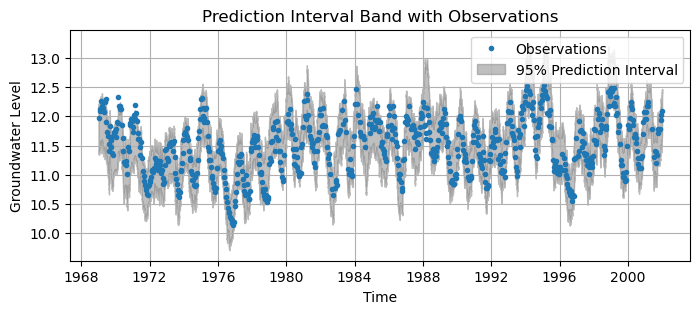

PICP: 0.956


In [16]:
plt.figure(figsize=(8, 3))
plt.plot(series.loc['1969':'2001'],'.', label='Observations')
plt.fill_between(pi.index, pi[0.025], pi[0.975], color='gray', alpha=0.5, label='95% Prediction Interval')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Groundwater Level')
plt.title('Prediction Interval Band with Observations')
plt.legend()
plt.grid()

# Show the plot
plt.show();
print(f'PICP: {ps.stats.picp(series[pi.index[0] : pi.index[-1]], pi):.3f}')

## 5 Compare pastas and emce

Here the values for three different analysis are put together. All of them perform similar. The MCMC values are taken from the results by Van Der Spel and Pastas values are calulated in notebook "Pastas frequentist analysis vs MCMC" 

In [17]:
table_data = [
    ["Metric", "MCMC","Pastas", "Emcee"],
    ["Normalized Confidence Interval (nCI)","0.08","0.084", f"{nci_mean:.3f}"],
    ["Normalized Prediction Interval (nPI)","0.45","0.445", f"{npi_mean:.3f}"]
]

# Print formatted table
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))

+--------------------------------------+------+--------+-------+
|                Metric                | MCMC | Pastas | Emcee |
+--------------------------------------+------+--------+-------+
| Normalized Confidence Interval (nCI) | 0.08 | 0.084  | 0.093 |
| Normalized Prediction Interval (nPI) | 0.45 | 0.445  | 0.453 |
+--------------------------------------+------+--------+-------+


## 6. Compare multiple datasets

Here we loop over the datasets and plot the normalised prediction interval and confidence interval together  with the values found by Van Der Spek:

In [18]:
## loop
results = []

for gw_levels in gw_levels_list:    
    series = gw_levels["stand_m_tov_nap"].dropna()               # Get rid of Nan-values
    ref_tindex = series.resample('2W').first().index             # Get an index for a bi-weekly observation data point
    tindex = series.index
    sel_index = ps.timeseries_utils.get_sample(tindex=tindex, ref_tindex=ref_tindex)
    series = series.loc[sel_index]                               # Add the observation points to the correct date.


    # First set proper time parameters:
    time = str(gw_levels.index[-1].year - 10)                             # Start validation is 10 years in the past.

    if gw_levels.index[0].year < (gw_levels.index[-1].year - 30):         # If statement which takes the best starting times for calibration and validation period.
        strtime = str(int(time) - 20)
    else:
        strtime = str(gw_levels.index[0].year + 1)                        # Pick the first complete year of the time series.
        time = str(int(strtime) + 20)                                     # In order to stay constitent, make sure there is a calibration period of 20 years

    # Load evap and Prec data from KNMI
    evaporation = hpd.EvaporationObs.from_knmi(
        xy=(gw_levels.x, gw_levels.y),                                    # Get nearest station
        meteo_var="EV24",                                                 # EV24; Use weather station
        start=gw_levels.index[0],
        end=gw_levels.index[-1],
        fill_missing_obs=True,
    )
    
    precipitation = hpd.PrecipitationObs.from_knmi(
        xy=(gw_levels.x, gw_levels.y),                                    # Get nearest station
        meteo_var= 'RD',                                                  # RD; Use the daily precipitaiton from nearest precipitation station
        start=gw_levels.index[0],
        end=gw_levels.index[-1],
        fill_missing_obs=True,
    )

    ml2 = ps.Model(series, name= gw_levels.name)
    ts1 = ps.RechargeModel(
        precipitation["RD"].resample("D").first() * 1000,       # Mind the UNITS !
        evaporation["EV24"].resample("D").first() * 1000,
        rfunc=ps.Gamma(),
        name="rainevap",
        recharge=ps.rch.Linear(),
        settings=("prec", "evap"),
    )
    ml2.add_stressmodel(ts1)
    nm = ps.ArNoiseModel()
    ml2.add_noisemodel(nm)
    
    # SOLVE MODEL
    ml2.solve(tmin=strtime, tmax=time, report=False)    # normally do this, but rn: compare to vd Spek
    
    # Set the initial parameters to a normal distribution
    ml2.parameters["initial"] = ml2.parameters["optimal"]  # set initial value to the optimal from least squares for good starting point
    for name in ml.parameters.index:
        if ml2.parameters.loc[name, "optimal"] > 0:
            ml2.set_parameter(name, dist="uniform",pmin=0.25 * ml2.parameters.loc[name, "optimal"], pmax=4 * ml2.parameters.loc[name, "optimal"])
        else:
            ml2.set_parameter(name, dist="uniform", pmin=4 * ml2.parameters.loc[name, "optimal"],pmax=0.25 * ml2.parameters.loc[name, "optimal"])

    # Choose the objective function of the Emce solver
    ln_prob = ps.objfunc.GaussianLikelihoodAr1()

    # Create the EmceeSolver with some settings
    s = ps.EmceeSolve(
        nwalkers=20,
        moves=emcee.moves.DEMove(),
        objective_function=ln_prob,
        progress_bar=True,
        parallel=False,
    )

    s.parameters.loc["ln_var", "initial"] = np.var(ml2.noise())
    s.parameters.loc["ln_var", "pmin"] = np.var(ml2.noise()) / 4
    s.parameters.loc["ln_var", "pmax"] = 4 * np.var(ml2.noise())

    ml2.del_noisemodel()
    
    ml2.solve(
        solver=s,
        initial=False,
        # fit_constant=False,
        tmin=strtime,
        tmax=time,
        steps=1000,
        tune=True,
        report=False
    )
    
    # Calculate the step response function
    step_response = ml2.get_step_response('rainevap')
    A_parameter = ml2.parameters.loc['rainevap_A', 'optimal']
    t90 = step_response.index[step_response.values >= 0.90 * A_parameter][0]
    
    # Calculate head range
    flattened = ml2.observations().values.flatten()
    h025, h50, h975 = pd.Series(flattened).quantile([0.025, 0.5, 0.975]) 
    head_range = h975-h025


    
    # calc CI
    params = ml2.solver.sampler.get_chain(flat=True, discard=500)
    sim_ci = {}
    for i in np.random.choice(np.arange(10000), size=1000, replace=False): # Loop that simulates the model for each parameter set and results in the modelled timeseries
        h = ml2.simulate(p=params[i])
        sim_ci[i] = h

    alpha = 0.05
    q = [alpha / 2, 1 - alpha / 2]
    sim_cidf = pd.DataFrame.from_dict(sim_ci, orient="columns", dtype=float)
    ci = sim_cidf.quantile(q, axis=1).transpose()
    cimean = np.mean(ci[0.975] - ci[0.025])
    nci_mean = cimean / head_range
    
    # calc PI
    sim = {}
    for i in np.random.choice(np.arange(10000), size=1000, replace=False):
        h = ml2.simulate(p=params[i, :-2])
        res = ml2.residuals(p=params[i, :-2])
        h += np.random.normal(loc=0, scale=np.std(res), size=len(h))
        sim[i] = h
    simdf = pd.DataFrame.from_dict(sim, orient="columns", dtype=float)
    pi = simdf.quantile(q, axis=1).transpose()
    pimean = np.mean(pi[0.975] - pi[0.025])
    npi_mean = pimean / head_range


    # Check PICP & NSE
    PICPe = ps.stats.picp(series[pi.index[0] : pi.index[-1]], pi)
    
    nse = ml2.stats.nse()

    
    results.append({
        "resp_t": t90, 
        'gw_level_name': gw_levels.name,
        "nse": nse, 
        "headrange": head_range, 
        "nci": nci_mean,
        "npi": npi_mean, 
        "picp": PICPe,
    })
    print('.', end='')                                                              # Indication of how many loops have taken place
    
results_df = pd.DataFrame(results)   

100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


.

100%|██████████| 1000/1000 [00:49<00:00, 20.35it/s]


.

100%|██████████| 1000/1000 [00:48<00:00, 20.80it/s]


.

100%|██████████| 1000/1000 [00:46<00:00, 21.33it/s]


.

100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


.

100%|██████████| 1000/1000 [00:50<00:00, 19.83it/s]


.

100%|██████████| 1000/1000 [00:48<00:00, 20.46it/s]


.

100%|██████████| 1000/1000 [00:50<00:00, 19.64it/s]


.

100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


.

100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]


.

100%|██████████| 1000/1000 [00:53<00:00, 18.85it/s]


.

100%|██████████| 1000/1000 [00:51<00:00, 19.54it/s]


.

100%|██████████| 1000/1000 [00:51<00:00, 19.32it/s]


.

100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]


.

100%|██████████| 1000/1000 [00:57<00:00, 17.50it/s]


.

100%|██████████| 1000/1000 [00:53<00:00, 18.55it/s]


.

100%|██████████| 1000/1000 [00:45<00:00, 22.06it/s]


.

100%|██████████| 1000/1000 [00:59<00:00, 16.88it/s]


.

### Results

In the loop, a few values are saved in order to check whether the values make sense: 
- Resp_t: The response time of the system.
- The NSE is the Nash-Sutcliff coefficient, which should be around 0.80 or higher. 
- Head range: Is the 95% head range of the observations. Used for the normalisation of the CI and PI
- nci & npi, the normalised confidence interval and prediction interval
- picp: The percentage of the observed groundwater levels that falls within the 95% prediction interval.


In [19]:
results_df

,resp_t,gw_level_name,nse,headrange,nci,npi,picp
0,309.0,B09B0124-001,0.854454,0.83475,0.053341,0.425950,0.947644
1,171.0,B09D0360-001,0.766312,1.39200,0.099121,0.590226,0.938931
2,121.0,B11C0329-001,0.743968,0.69175,0.092044,0.560799,0.947005
3,376.0,B12B0001-001,0.850717,1.34050,0.103307,0.416656,0.954545
4,510.0,B12G0075-001,0.891461,1.57800,0.069812,0.338382,0.957447
5,143.0,B22C0090-001,0.827952,1.46000,0.069691,0.442266,0.967366
6,68.0,B27H0042-001,0.744811,0.60575,0.081121,0.518580,0.949761
7,266.0,B32C0572-001,0.799532,0.88300,0.094684,0.470006,0.947368
8,581.0,B32E0031-001,0.835992,1.63775,0.117921,0.471883,0.966667
9,553.0,B33B0505-001,0.619924,1.32925,0.311608,0.660787,0.978022


In [20]:
# Read the data into a DataFrame
df_CI = pd.read_csv('data/nCI_spek.txt', comment='#', header=None, names=['X', 'Y'])
df_PI = pd.read_csv('data/nPI_spek.txt', comment='#', header=None, names=['X', 'Y'])

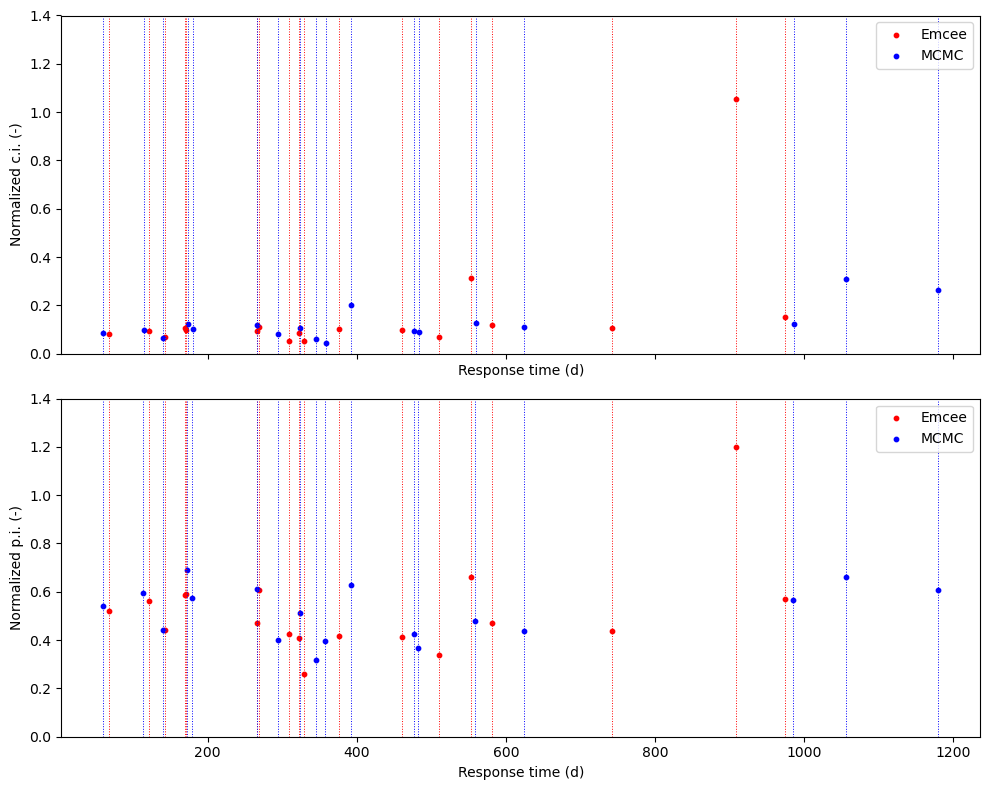

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Confidence Interval (CI) Plot
axes[0].scatter(results_df['resp_t'], results_df['nci'], color='red', s=10, label="Emcee")
axes[0].vlines(results_df['resp_t'], ymin=0, ymax=1.4, colors='red', linestyles='dotted', linewidth=0.7)

axes[0].scatter(df_CI['X'], df_CI['Y'], color='blue', s=10, label="MCMC") 
axes[0].vlines(df_CI['X'], ymin=0, ymax=1.4, colors='blue', linestyles='dotted', linewidth=0.7)

axes[0].set_ylim(0, 1.4)
axes[0].set_xlabel("Response time (d)")
axes[0].set_ylabel("Normalized c.i. (-)")
axes[0].legend()

# Prediction Interval (PI) Plot
axes[1].scatter(results_df['resp_t'], results_df['npi'], color='red', s=10, label="Emcee")
axes[1].vlines(results_df['resp_t'], ymin=0, ymax=1.4, colors='red', linestyles='dotted', linewidth=0.7)

axes[1].scatter(df_PI['X'], df_PI['Y'], color='blue', s=10, label="MCMC") 
axes[1].vlines(df_PI['X'], ymin=0, ymax=1.4, colors='blue', linestyles='dotted', linewidth=0.7)

axes[1].set_ylim(0, 1.4)
axes[1].set_xlabel("Response time (d)")
axes[1].set_ylabel("Normalized p.i. (-)")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

Comparing both plots, we can see that the response time is different for both methods, but the values of the normalised prediction and confidence interval are similar, with one outlier. Getting relatively similar results with the use of the EmceeSolver in comparinson to an extensive MCMC analysis, gives an indication of the solvers potential.

### Sources Used:

- Van der Spek, J. E., and M. Bakker (2017), The influence of the length of the calibration period and observation frequency on predictive uncertainty in time series modeling of groundwater dynamics, Water Resour. Res., 53, 2294–2311, doi:10.1002/2016WR019704, from:[https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019704). 

Data:
- KNMI, Koninklijk Nederlands Meteorologisch Instituut, from [https://dataplatform.knmi.nl](https://dataplatform.knmi.nl)

- DINOloket, Data en Informatie van de Nederlandse Ondergrond, from [https://www.dinoloket.nl/ondergrondgegevens](https://www.dinoloket.nl/ondergrondgegevens)